In [7]:
#Importing Libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import PIL.ImageOps
import requests
from torch import nn
from torchvision import datasets, transforms
from PIL import Image


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [9]:
batch_size = 100
learning_rate = 0.001
epochs = 20

In [10]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
train_dataset = datasets.CIFAR10(root='.././data/cfar-10', train=True, download=True, transform=transform_train)
val_dataset = datasets.CIFAR10(root='.././data/cfar-10', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
def image_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [12]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


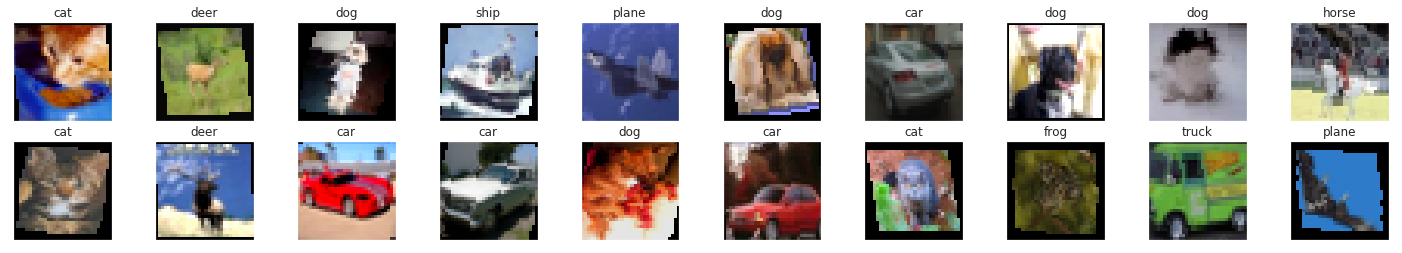

In [13]:
import seaborn as sns
sns.set()

dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title(class_names[labels[idx].item()])

In [14]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [15]:
## Initialize model
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [17]:
# Print model's number of trainable parameters

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

541094


In [18]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([16, 3, 3, 3])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 3, 3])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 3, 3])
conv3.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([500, 1024])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])


In [19]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
param_groups 	 [{'betas': (0.9, 0.999), 'amsgrad': False, 'params': [140562070310984, 140562070311056, 140562070311128, 140562070311200, 140562070311272, 140562070311344, 140562070311416, 140562070311488, 140562070311560, 140562070311632], 'eps': 1e-08, 'weight_decay': 0, 'lr': 0.001}]
state 	 {}


In [ ]:
#Training the Network
training_loss_history = []
training_corrects_history = []
val_loss_history = []
val_corrects_history = []
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  # train the model #

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  
  # validate the model 

  else:
    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(train_loader.dataset) 
    epoch_acc = running_corrects.float()/ len(train_loader.dataset)  

    training_loss_history.append(epoch_loss)
    training_corrects_history.append(epoch_acc)
    val_epoch_loss = val_running_loss/len(val_loader.dataset) 
    val_epoch_acc = val_running_corrects.float()/ len(val_loader.dataset) 
    val_loss_history.append(val_epoch_loss)
    val_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0170, acc 0.3801 
validation loss: 0.0143, validation acc 0.4799 
epoch : 2
training loss: 0.0141, acc 0.4898 
validation loss: 0.0126, validation acc 0.5441 
epoch : 3
training loss: 0.0128, acc 0.5406 
validation loss: 0.0115, validation acc 0.5849 
epoch : 4
training loss: 0.0119, acc 0.5760 
validation loss: 0.0107, validation acc 0.6241 
epoch : 5
training loss: 0.0112, acc 0.6021 
validation loss: 0.0101, validation acc 0.6424 
epoch : 6
training loss: 0.0108, acc 0.6236 
validation loss: 0.0099, validation acc 0.6525 
epoch : 7
training loss: 0.0103, acc 0.6361 
validation loss: 0.0096, validation acc 0.6647 
epoch : 8
training loss: 0.0101, acc 0.6468 
validation loss: 0.0090, validation acc 0.6852 
epoch : 9
training loss: 0.0098, acc 0.6597 
validation loss: 0.0088, validation acc 0.6928 
epoch : 10
training loss: 0.0095, acc 0.6699 
validation loss: 0.0090, validation acc 0.6832 
epoch : 11
training loss: 0.0092, acc 0.6751 
validation loss: 0.0084

In [ ]:
#plot the training and validation loss
plt.plot(training_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.suptitle('Training loss vs Test loss', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend()

In [ ]:
#plot the training and validation accuracy

plt.plot(training_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.suptitle('Training Accuracy vs validation Accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend()

In [ ]:
#Predicting the Category for all Test Images
# Confusion_matrix

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

In [ ]:
#class_wise accuracy

print('{0:10s} : {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} : {1:.1f}'.format(class_names[i], r[i]/np.sum(r)*100))

In [ ]:
#plot confusion matrix

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), class_names)
plt.xlabel('Predicted Category')
plt.xticks(range(10), class_names)
plt.show()

In [ ]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(class_names):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(class_names[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

In [ ]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(class_names):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(class_names[i].ljust(16), end='')
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

In [ ]:
# plot the images in the batch, along with predicted and true labels
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(15, 7))

for idx in np.arange(15):
  ax = fig.add_subplot(3, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(class_names[preds[idx].item()]), str(class_names[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
#test image from internet with the model 
url = 'https://www.akc.org/wp-content/themes/akc/component-library/assets/img/welcome.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [ ]:
img = transform(img) 
plt.imshow(image_convert(img))

In [ ]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(class_names[pred.item()])